# Deduplication

A more comprehensive and scripted version of this same workflow exists in datasets/dededuplicated/deduplicate.py.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import SimpleITK as sitk
import imagehash
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
#read in the tif example volume
#if testing another volume, just change this next line
#to point to its filepath
vol = sitk.ReadImage('example_data/deduplication/filter_column.tif')
#convert it to a numpy array
vol = sitk.GetArrayFromImage(vol)
print('Volume of size:', vol.shape)

Volume of size: (600, 224, 224)


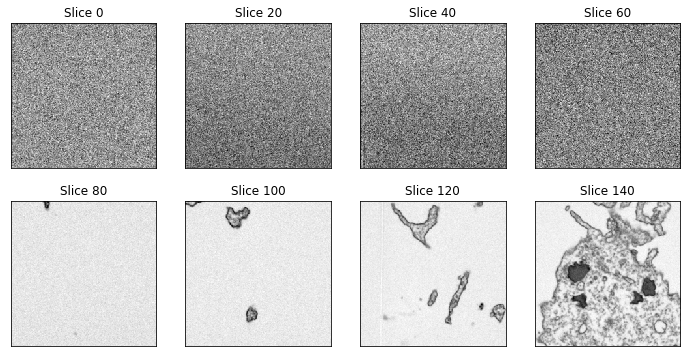

In [7]:
#plot a few images from the xy plane
f, ax = plt.subplots(2, 4, figsize=(12, 6))

i = 0
for y in range(2):
    for x in range(4):
        ax[y, x].imshow(vol[i], cmap='gray')
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].set_title(f'Slice {i}')
        i += 20

In [8]:
def calculate_hash(image, crop_size, hash_size=8):
    #Creates the dhash for the resized image
    #this guarantees that smaller images are not more likely
    #to be recognized as unique
    return imagehash.dhash(Image.fromarray(image).resize((crop_size, crop_size), 2), hash_size=hash_size).hash

In [9]:
#for simplicity, we'll only consider images from the imaging plane for now
#calculate the difference hashes for each
hashes = np.array([calculate_hash(img, 224, 8).ravel() for img in vol])
print(f'{hashes.shape[0]} hashes of {hashes.shape[1]}-bits each')

#make a list of exemplar images to keep
exemplars = []
exemplar_matches = []
min_distance = 12 #Hamming distance threshold for considering images a match
images = np.copy(vol)

#loop through the hashes and assign images to sets of near duplicates
#until all of the hashes are exhausted
while len(hashes) > 0:
    #the reference hash is the first one in the list
    #of remaining hashes
    ref_hash = hashes[0]

    #a match has Hamming distance less than min_distance
    matches = np.where(np.logical_xor(ref_hash, hashes).sum(1) <= min_distance)[0]

    #choose the first match as the exemplar and add
    #it's filepath to the list. this is random because we
    #permuted the paths earlier. a different image could be
    #chosen on another run of this script
    
    #NOTE: just for demonstration purposes
    #the selection of the exemplar is deterministic
    #(i.e. always the first in the group).
    #in the real deduplication script, the
    #images are permutated to be in a random order
    exemplars.append(images[matches[0]])
    exemplar_matches.append(images[matches[1:]])

    #remove all the matched images from both hashes and impaths
    hashes = np.delete(hashes, matches, axis=0)
    images = np.delete(images, matches, axis=0)
    
print(f'Extracted {len(exemplars)} exemplars and {sum([em.shape[0] for em in exemplar_matches])} near-duplicates')

600 hashes of 64-bits each
Extracted 158 exemplars and 442 near-duplicates


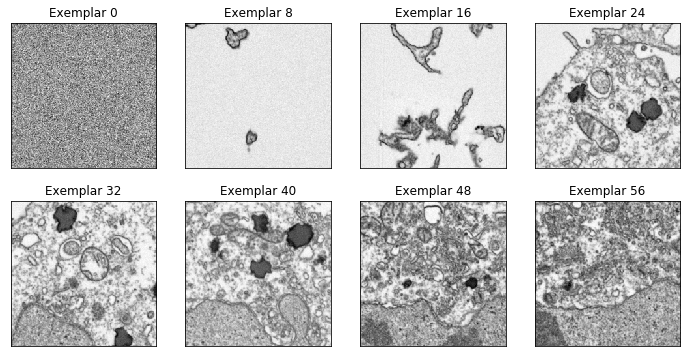

In [10]:
#plot some exemplar images
f, ax = plt.subplots(2, 4, figsize=(12, 6), squeeze=False)

i = 0
for y in range(2):
    for x in range(4):
        ax[y, x].imshow(exemplars[i], cmap='gray')
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].set_title(f'Exemplar {i}')
        i += 8

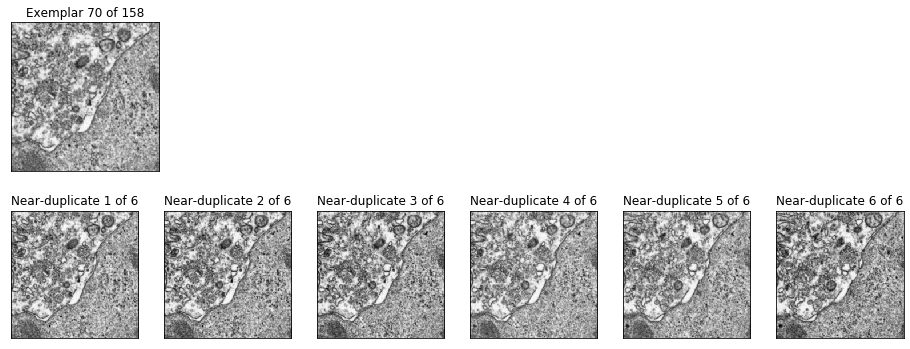

In [11]:
#index for exemplar image
index = 70

fig = plt.figure(figsize=(16, 6))
outer = gridspec.GridSpec(2, 1)

inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0], wspace=0, hspace=0)
ax = plt.Subplot(fig, inner[0])
ax.imshow(exemplars[index], cmap='gray')
ax.set_title(f'Exemplar {index} of {len(exemplars)}')
fig.add_subplot(ax)

cols = min(6, len(exemplar_matches[index]))
if cols == 0:
    print('No matches for exemplar!')
else:
    rows = 1
    inner = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=outer[1])
    for x in range(cols * rows):
        ax = plt.Subplot(fig, inner[x])
        ax.imshow(exemplar_matches[index][x], cmap='gray')
        ax.set_title(f'Near-duplicate {x+1} of {len(exemplar_matches[index])}')
        fig.add_subplot(ax)
        
for ax in fig.axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_anchor('W')

# Filtering

In this sections, we'll take the exemplar images that we discovered and filter out the uninformative ones. Typically, this would require the manual labeling of some images (see the labeling.ipynb notebook) and then the training of a classifier. For this example, we'll just use the NN classifier trained on a set of 12K images from deduplicated CellEMNet.

In [12]:
import cv2
import torch.hub
from torch.nn import Sigmoid
from torchvision.models import resnet34
from torchvision.transforms import Compose, ToTensor, Normalize

In [13]:
#download the model state
model_url = 'https://www.dropbox.com/s/2libiwgx0qdgxqv/patch_quality_classifier_nn.pth?raw=1'
model_state = torch.hub.load_state_dict_from_url(model_url)

In [14]:
#create the resnet34 model with a single output class
model = resnet34(num_classes=1)

#load the model state dict
msg = model.load_state_dict(model_state)

In [15]:
#set the model to eval mode
model.eval()

#now we're ready to run inference over all of the exemplar images
#if working with a large dataset, we would want this to run on GPU,
#but for a few dozen images, CPU is just fine
predictions = []
for image in exemplars:
    #image is numpy array of size (H, W)
    #first make the image with 3 grayscale channels
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) #(H, W) --> (H, W, 3)
    
    #resize the image to (224, 224, 3)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    #apply evaluation transforms:
    #convert to a tensor and normalize
    #using ImageNet mean and std pixel values
    tfs = Compose([
        ToTensor(),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    
    #apply transforms and unsqueeze batch dim
    #(H, W, 3) --> (1, 3, H, @)
    image = tfs(image).unsqueeze(0)
    
    #evaluate the image and store the prediction
    with torch.no_grad():
        prediction = model(image)
        prediction = Sigmoid()(prediction)
    
    predictions.append(prediction.item())
    
predictions = np.array(predictions)

In [16]:
#predictions are confidence scores (i.e. [0-1])
#get the indices of exemplars labeled informative and
#those labeled uninformative
predicted_informative = np.where(predictions >= 0.5)[0]
predicted_uninformative = np.where(predictions < 0.5)[0]
print(f'{len(predicted_informative)} exemplars marked as informative')
print(f'{len(predicted_uninformative)} exemplars marked as uninformative')

77 exemplars marked as informative
81 exemplars marked as uninformative


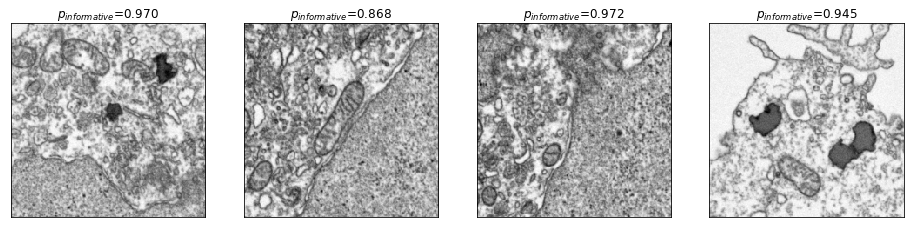

In [17]:
#let's randomly pick and plot some informative images
#along with their prediction confidences
indices = np.random.choice(predicted_informative, (4,), replace=False)
f, ax = plt.subplots(1, 4, figsize=(16, 4), squeeze=False)

i = 0
for y in range(1):
    for x in range(4):
        index = indices[i]
        ax[y, x].imshow(exemplars[index], cmap='gray')
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].set_title('$p_{informative}$=' + f'{predictions[index]:.3f}')
        i += 1

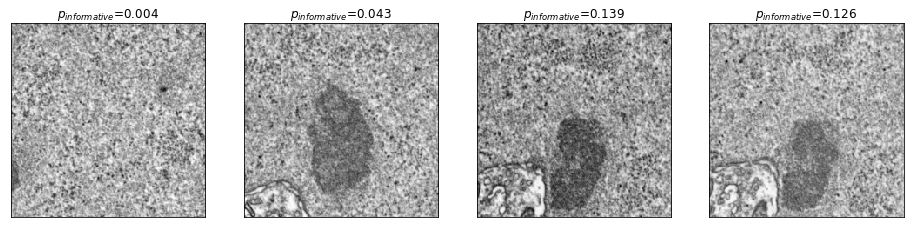

In [18]:
#let's randomly pick and plot some uninformative images
#along with their prediction confidences
indices = np.random.choice(predicted_uninformative, (4,), replace=False)
f, ax = plt.subplots(1, 4, figsize=(16, 4), squeeze=False)

i = 0
for y in range(1):
    for x in range(4):
        index = indices[i]
        ax[y, x].imshow(exemplars[index], cmap='gray')
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].set_title('$p_{informative}$=' + f'{predictions[index]:.3f}')
        i += 1